Creating dataset...
Dataset created with 500 samples

First 5 rows of data:
  ticker       date  quarter      sector  surprise_pct  pre_volatility  \
0   AMZN 2020-11-08        4    Consumer         -5.56            2.11   
1   MSFT 2023-12-21        4  Technology          7.31            4.55   
2  GOOGL 2023-07-20        3  Technology         -2.72            1.81   
3   AMZN 2020-08-15        3    Consumer         -1.93            0.57   
4   MSFT 2021-12-02        4  Technology          3.49            1.45   

   volume_spike  price_change_pct  target  
0          3.84             -0.51       0  
1          1.19              7.82       1  
2          0.63             -4.04       0  
3          0.75              1.22       1  
4          2.17             -0.40       0  

Preparing features...
Training set: 375 samples
Test set: 125 samples

Training models...

Evaluating models...

Logistic Regression Results:
Accuracy: 0.6240
Precision: 0.6633
Recall: 0.8228
Confusion Matrix:
[[13

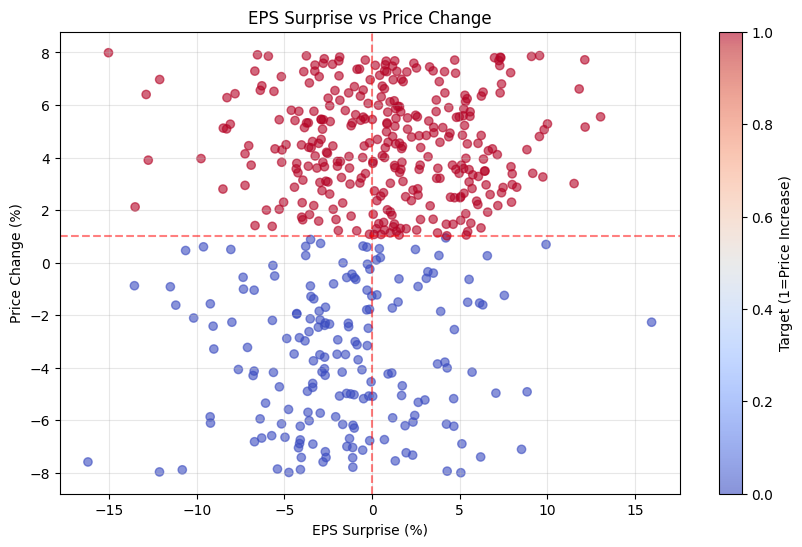

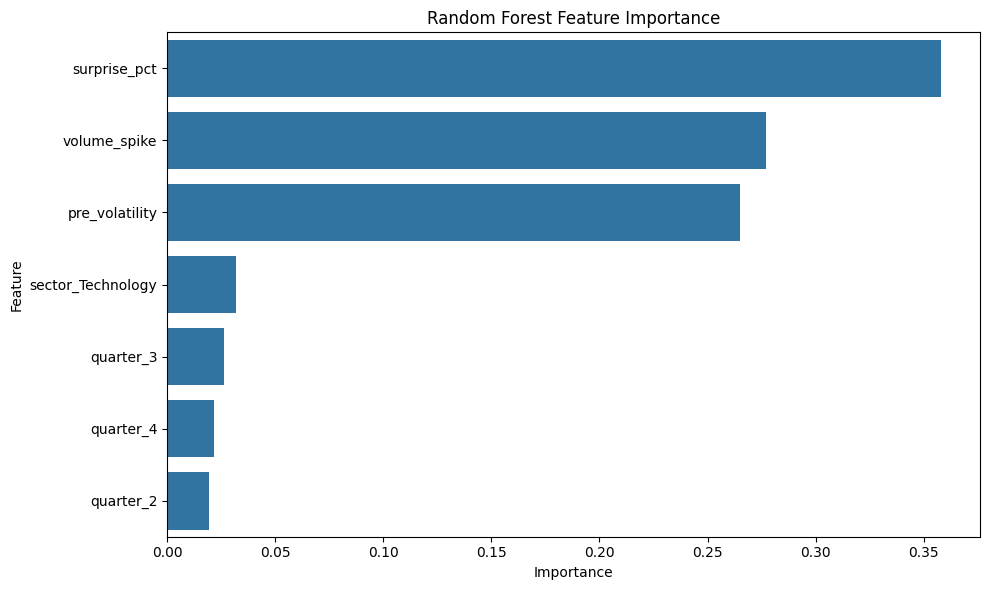

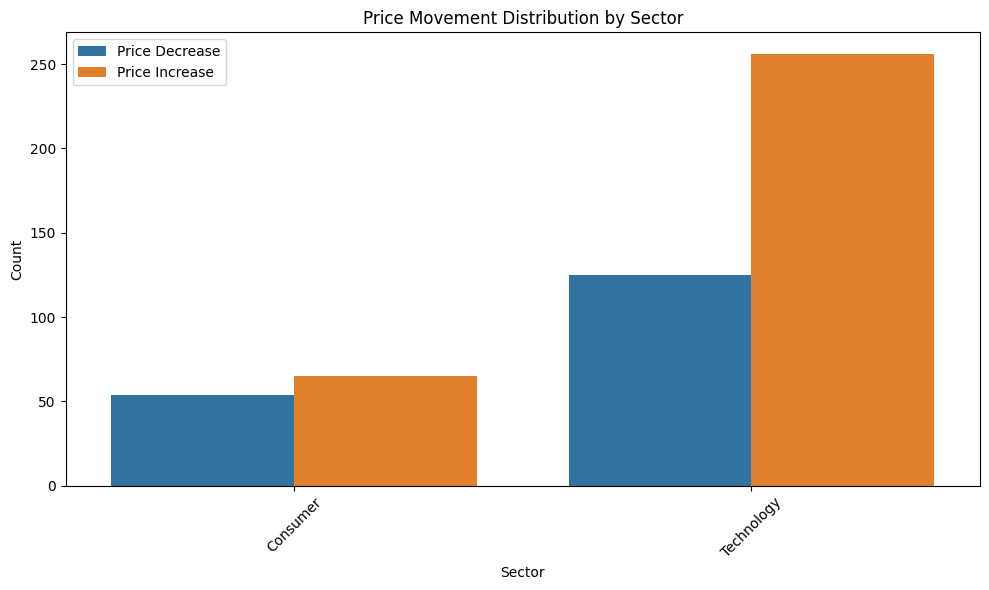

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Create a simple dataset for demonstration
def create_demo_dataset(n_samples=500):
    """Create a demonstration dataset for earnings prediction"""
    np.random.seed(42)

    # List of tickers and sectors
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
    sectors = ['Technology', 'Technology', 'Technology', 'Consumer', 'Technology']
    ticker_to_sector = dict(zip(tickers, sectors))

    data = []

    for _ in range(n_samples):
        # Randomly select a ticker
        ticker_idx = np.random.randint(0, len(tickers))
        ticker = tickers[ticker_idx]
        sector = ticker_to_sector[ticker]

        # Create date (just for reference)
        year = np.random.randint(2020, 2024)
        month = np.random.randint(1, 13)
        day = np.random.randint(1, 29)
        date = datetime(year, month, day)

        # Determine quarter
        quarter = (month - 1) // 3 + 1

        # Create features
        surprise_pct = np.random.normal(0, 5)  # EPS surprise percentage
        pre_volatility = np.random.gamma(2, 1)  # Pre-announcement volatility
        volume_spike = np.random.gamma(1.5, 1)  # Volume spike

        # Probability increases with positive surprise and tech sector
        prob_increase = 0.5
        # Positive surprise increases probability
        if surprise_pct > 0:
            prob_increase += 0.2
        # Tech sector reacts more to surprise
        if sector == 'Technology' and surprise_pct > 0:
            prob_increase += 0.1
        # Add some randomness
        prob_increase += np.random.normal(0, 0.1)

        # Keep probability between 0.1 and 0.9
        prob_increase = max(0.1, min(0.9, prob_increase))

        # Determine target (1 if price increased, 0 otherwise)
        target = 1 if np.random.random() < prob_increase else 0

        # Generate price change percentage
        if target == 1:
            price_change_pct = np.random.uniform(1.0, 8.0)
        else:
            price_change_pct = np.random.uniform(-8.0, 1.0)

        # Add data point
        data.append({
            'ticker': ticker,
            'date': date,
            'quarter': quarter,
            'sector': sector,
            'surprise_pct': round(surprise_pct, 2),
            'pre_volatility': round(pre_volatility, 2),
            'volume_spike': round(volume_spike, 2),
            'price_change_pct': round(price_change_pct, 2),
            'target': target  # 1 if price increased, 0 otherwise
        })

    return pd.DataFrame(data)

# Run the entire prediction process
def run_earnings_prediction():
    """Run the full earnings prediction process"""
    # Step 1: Create dataset
    print("Creating dataset...")
    df = create_demo_dataset(500)
    print(f"Dataset created with {len(df)} samples")

    # Show the first few rows
    print("\nFirst 5 rows of data:")
    print(df.head())

    # Step 2: Prepare features
    print("\nPreparing features...")
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=['sector', 'quarter'], drop_first=True)

    # Select features
    feature_cols = ['surprise_pct', 'pre_volatility', 'volume_spike']
    # Add encoded categorical columns
    feature_cols += [col for col in df_encoded.columns if col.startswith('sector_') or col.startswith('quarter_')]

    X = df_encoded[feature_cols]
    y = df_encoded['target']

    # Scale numerical features
    scaler = StandardScaler()
    X[['surprise_pct', 'pre_volatility', 'volume_spike']] = scaler.fit_transform(
        X[['surprise_pct', 'pre_volatility', 'volume_spike']])

    # Step 3: Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Step 4: Train models
    print("\nTraining models...")

    # Logistic Regression
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Step 5: Evaluate models
    print("\nEvaluating models...")

    # Function to evaluate and print metrics
    def evaluate_model(model, name):
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print("Confusion Matrix:")
        print(cm)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
        }

    # Evaluate both models
    log_metrics = evaluate_model(log_reg, "Logistic Regression")
    rf_metrics = evaluate_model(rf, "Random Forest")

    # Step 6: Feature importance
    print("\nAnalyzing feature importance...")

    # For Logistic Regression
    log_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': np.abs(log_reg.coef_[0])
    }).sort_values('Importance', ascending=False)

    print("\nLogistic Regression Feature Importance:")
    print(log_importance.head())

    # For Random Forest
    rf_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nRandom Forest Feature Importance:")
    print(rf_importance.head())

    # Step 7: Visualizations
    print("\nCreating visualizations...")

    # Plot 1: EPS surprise vs price change
    plt.figure(figsize=(10, 6))
    plt.scatter(df['surprise_pct'], df['price_change_pct'],
               alpha=0.6, c=df['target'], cmap='coolwarm')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=0.0, color='r', linestyle='--', alpha=0.5)
    plt.colorbar(label='Target (1=Price Increase)')
    plt.xlabel('EPS Surprise (%)')
    plt.ylabel('Price Change (%)')
    plt.title('EPS Surprise vs Price Change')
    plt.grid(True, alpha=0.3)
    plt.savefig('surprise_vs_price.png')

    # Plot 2: Feature importance (Random Forest)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=rf_importance.head(10))
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    # Plot 3: Target distribution by sector
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sector', hue='target', data=df)
    plt.xlabel('Sector')
    plt.ylabel('Count')
    plt.title('Price Movement Distribution by Sector')
    plt.legend(['Price Decrease', 'Price Increase'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('sector_distribution.png')

    print("\nDemo completed successfully!")
    print("Three visualization files have been created:")
    print("1. surprise_vs_price.png")
    print("2. feature_importance.png")
    print("3. sector_distribution.png")

    # Return models and data for further analysis if needed
    return {
        'data': df,
        'logistic_regression': log_reg,
        'random_forest': rf,
        'log_metrics': log_metrics,
        'rf_metrics': rf_metrics,
        'feature_importance': rf_importance
    }

# Run the demo
if __name__ == "__main__":
    run_earnings_prediction()

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

class SimpleEarningsPredictor:
    def __init__(self, start_date='2020-01-01', end_date='2023-12-31'):
        """
        Initialize the SimpleEarningsPredictor class.

        Args:
            start_date (str): The start date for data collection (YYYY-MM-DD)
            end_date (str): The end date for data collection (YYYY-MM-DD)
        """
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.model = None

    def generate_sample_data(self, tickers, n_samples=None):
        """
        Generate sample data for earnings events.

        Args:
            tickers (list): List of ticker symbols
            n_samples (int): Number of samples per ticker (if None, will generate quarterly samples)

        Returns:
            DataFrame: Generated sample data
        """
        all_data = []

        # Sample sectors for the tickers
        sectors = {
            'AAPL': 'Technology', 'MSFT': 'Technology', 'GOOGL': 'Technology',
            'AMZN': 'Consumer', 'META': 'Technology', 'NFLX': 'Consumer',
            'TSLA': 'Automotive', 'JPM': 'Finance', 'BAC': 'Finance', 'DIS': 'Entertainment'
        }

        for ticker in tickers:
            print(f"Generating data for {ticker}")

            # Create earnings dates (quarterly)
            if n_samples is None:
                # Generate quarterly dates
                earnings_dates = pd.date_range(start=self.start_date, end=self.end_date, freq='3M')
            else:
                # Generate random dates
                earnings_dates = pd.date_range(start=self.start_date, end=self.end_date, periods=n_samples)

            for date in earnings_dates:
                # Generate features
                surprise_pct = np.random.normal(0, 5)  # EPS surprise percentage
                pre_volatility = np.random.gamma(2, 1)  # Pre-announcement volatility
                volume_spike = np.random.gamma(1.5, 1)  # Volume spike

                # Determine quarter
                quarter = (date.month - 1) // 3 + 1

                # Set sector
                sector = sectors.get(ticker, 'Other')

                # Target is influenced by surprise, sector, and some randomness
                # Technology stocks tend to react more positively to earnings
                tech_boost = 0.2 if sector == 'Technology' else 0
                surprise_factor = 0.3 if surprise_pct > 0 else -0.2

                # Calculate probability of price increase
                p_increase = 0.5 + surprise_factor + tech_boost + np.random.normal(0, 0.3)
                p_increase = max(0.1, min(0.9, p_increase))  # Bound between 0.1 and 0.9

                # Determine target (1 if price increased, 0 otherwise)
                target = 1 if np.random.random() < p_increase else 0

                # Simulate price change percentage
                if target == 1:
                    price_change_pct = np.random.uniform(1.0, 8.0)
                else:
                    price_change_pct = np.random.uniform(-8.0, 1.0)

                # Create sample data point
                data_point = {
                    'ticker': ticker,
                    'date': date,
                    'surprise_pct': round(surprise_pct, 2),
                    'pre_volatility': round(pre_volatility, 2),
                    'volume_spike': round(volume_spike, 2),
                    'quarter': quarter,
                    'sector': sector,
                    'price_change_pct': round(price_change_pct, 2),
                    'target': target
                }

                all_data.append(data_point)

        # Convert to DataFrame
        self.data = pd.DataFrame(all_data)

        # One-hot encode categorical variables
        self.data = pd.get_dummies(self.data, columns=['sector', 'quarter'], drop_first=True)

        return self.data

    def prepare_model_data(self):
        """
        Prepare the data for modeling.

        Returns:
            tuple: X_train, X_test, y_train, y_test
        """
        if self.data is None:
            raise ValueError("Data must be generated before preparing for modeling")

        # Select features (excluding non-feature columns)
        feature_cols = [col for col in self.data.columns
                        if col not in ['ticker', 'date', 'price_change_pct', 'target']]

        X = self.data[feature_cols]
        y = self.data['target']

        # Scale numerical features
        numerical_cols = ['surprise_pct', 'pre_volatility', 'volume_spike']
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        return X_train, X_test, y_train, y_test, feature_cols

    def train_model(self, X_train, y_train, model_type='logistic'):
        """
        Train a machine learning model.

        Args:
            X_train (DataFrame): Training features
            y_train (Series): Training target variable
            model_type (str): Type of model to train ('logistic' or 'random_forest')

        Returns:
            object: Trained model
        """
        if model_type == 'logistic':
            model = LogisticRegression(max_iter=1000, random_state=42)
        elif model_type == 'random_forest':
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            raise ValueError("model_type must be 'logistic' or 'random_forest'")

        model.fit(X_train, y_train)
        self.model = model

        return model

    def evaluate_model(self, X_test, y_test):
        """
        Evaluate the trained model.

        Args:
            X_test (DataFrame): Test features
            y_test (Series): Test target variable

        Returns:
            dict: Model evaluation metrics
        """
        if self.model is None:
            raise ValueError("Model must be trained before evaluation")

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # Print evaluation results
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print("\nConfusion Matrix:")
        print(metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        return metrics

    def get_feature_importance(self, feature_names):
        """
        Get feature importance from the trained model.

        Args:
            feature_names (list): List of feature names

        Returns:
            DataFrame: Feature importance values
        """
        if self.model is None:
            raise ValueError("Model must be trained before getting feature importance")

        if hasattr(self.model, 'coef_'):
            # Logistic Regression
            importance = abs(self.model.coef_[0])
        elif hasattr(self.model, 'feature_importances_'):
            # Random Forest
            importance = self.model.feature_importances_
        else:
            raise ValueError("Model does not have feature importance attribute")

        # Create DataFrame of feature importance
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        return importance_df

    def visualize_results(self):
        """
        Visualize the results of the analysis.
        """
        if self.data is None:
            raise ValueError("Data must be generated before visualization")

        # 1. Visualize EPS surprise vs price change
        plt.figure(figsize=(10, 6))
        plt.scatter(self.data['surprise_pct'], self.data['price_change_pct'],
                   alpha=0.6, c=self.data['target'], cmap='coolwarm')
        plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=0.0, color='r', linestyle='--', alpha=0.5)
        plt.colorbar(label='Target (1=Price Increase)')
        plt.xlabel('EPS Surprise (%)')
        plt.ylabel('3-Day Price Change (%)')
        plt.title('EPS Surprise vs Price Change')
        plt.grid(True, alpha=0.3)
        plt.savefig('surprise_vs_price_change.png')
        plt.close()

        # 2. Target distribution by sector
        sector_cols = [col for col in self.data.columns if col.startswith('sector_')]
        if sector_cols:
            # Reconstruct sector column
            self.data['sector'] = 'Other'  # Default value
            for col in sector_cols:
                sector_name = col.replace('sector_', '')
                self.data.loc[self.data[col] == 1, 'sector'] = sector_name

            # Plot target distribution by sector
            plt.figure(figsize=(10, 6))
            sns.countplot(x='sector', hue='target', data=self.data)
            plt.xlabel('Sector')
            plt.ylabel('Count')
            plt.title('Distribution of Price Movement by Sector')
            plt.legend(['Price Decrease', 'Price Increase'])
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('target_by_sector.png')
            plt.close()

        # 3. Feature importance if model is trained
        if self.model is not None and hasattr(self, 'feature_names'):
            importance_df = self.get_feature_importance(self.feature_names)

            plt.figure(figsize=(10, 6))
            plt.barh(importance_df['Feature'], importance_df['Importance'])
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.title('Feature Importance')
            plt.tight_layout()
            plt.savefig('feature_importance.png')
            plt.close()

        print("Visualizations saved as PNG files.")

def main():
    # List of tickers to analyze
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NFLX', 'TSLA', 'JPM', 'BAC', 'DIS']

    # Initialize the predictor
    predictor = SimpleEarningsPredictor(start_date='2020-01-01', end_date='2023-12-31')

    # Generate sample data
    print("Generating sample data...")
    data = predictor.generate_sample_data(tickers)

    # Save the data to CSV
    data.to_csv('earnings_data.csv', index=False)
    print("Sample data saved to 'earnings_data.csv'")

    # Prepare data for modeling
    print("\nPreparing data for modeling...")
    X_train, X_test, y_train, y_test, feature_cols = predictor.prepare_model_data()
    predictor.feature_names = feature_cols

    # Train and evaluate logistic regression model
    print("\nTraining logistic regression model...")
    predictor.train_model(X_train, y_train, model_type='logistic')
    print("\nEvaluating logistic regression model...")
    predictor.evaluate_model(X_test, y_test)

    # Train and evaluate random forest model
    print("\nTraining random forest model...")
    predictor.train_model(X_train, y_train, model_type='random_forest')
    print("\nEvaluating random forest model...")
    predictor.evaluate_model(X_test, y_test)

    # Get feature importance
    importance_df = predictor.get_feature_importance(feature_cols)
    print("\nFeature Importance:")
    print(importance_df)

    # Visualize results
    print("\nVisualizing results...")
    predictor.visualize_results()

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

Generating sample data...
Generating data for AAPL
Generating data for MSFT
Generating data for GOOGL
Generating data for AMZN
Generating data for META
Generating data for NFLX
Generating data for TSLA
Generating data for JPM
Generating data for BAC
Generating data for DIS
Sample data saved to 'earnings_data.csv'

Preparing data for modeling...

Training logistic regression model...

Evaluating logistic regression model...
Accuracy: 0.6500
Precision: 0.6875
Recall: 0.8462

Confusion Matrix:
[[ 4 10]
 [ 4 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.29      0.36        14
           1       0.69      0.85      0.76        26

    accuracy                           0.65        40
   macro avg       0.59      0.57      0.56        40
weighted avg       0.62      0.65      0.62        40


Training random forest model...

Evaluating random forest model...
Accuracy: 0.6500
Precision: 0.7727
Recall: 0.6538

Confusion Matri